<center>
    
# Plotting the shear profile of the E06 floating lidar data utilising the WRA Data Model and the brightwind library
## by
## Stephen Holleran (BrightWind), 26-Oct-2023

</center>


This is a notebook demonstrating some of the benefits of the Task 43 WRA Data Model using it with real data and the brightwind Python library. The brightwind library is an open-source Python library specifically developed for processing wind resource data. It can be installed using `pip install brightwind` and it's GitHub repo here: https://github.com/brightwind-dev/brightwind

The timeseries data used here is publicly available for download at: https://oswbuoysny.resourcepanorama.dnv.com/.
The WRA Data Model formatted JSON file for the E06 floating lidar was created by Daniel Nuno of Eolos and can be found in the 'demo_data' folder of this repository.

This Notebook builds on the [Notebook](https://github.com/IEA-Task-43/digital_wra_data_standard/blob/e590563e9f6d6987c5f267055f0b542be0970f2e/tools/2023%20Workshop%20-%20Floating%20Lidar%20Demo%20-%20Daniel%20Nuno.ipynb) presented by Daniel Nuno (Eolos) during the [2023 Workshop](https://github.com/IEA-Task-43/digital_wra_data_standard/wiki/Presentations).

In [1]:
import brightwind as bw
import pandas as pd
import pprint as pp

## Load in WRA Data Model file

Create a measurement station object using the E06 floating lidar WRA Data Model formatted JSON file produced by Eolos.

In [2]:
e06_data_model_file = '../demo_data/E06_wraMetaData.json' # this file is located in the 'demo_data' folder of the GitHub repository.
meas_sta = bw.MeasurementStation(e06_data_model_file)

### Show the measurement station's high level info along with the vertical profiler properties

In [3]:
meas_sta.get_table()

,1,2
Name,E06,E06
Latitude [ddeg],39.545000,39.545000
Longitude [ddeg],-73.429500,-73.429500
Measurement Station Type,floating_lidar,floating_lidar
Notes,EOLOS Floating Lidar buoy EOL-FLS200.,EOLOS Floating Lidar buoy EOL-FLS200.
Device Datum Plane Height [m],1.600000,-0.800000
Height Reference,mean_sea_level,mean_sea_level
Device Vertical Orientation,upward,downward
Vert. Prof. Prop. Notes,The ZXLidars ZX300M has 10 heights configured.,"The ADCP Nortek Signature 500 has 22 cells, with a cell size of 2.7 m and a blanking distance of 2.2 m."
Date From,2019-09-04T00:00:00,2019-09-04T00:00:00


The Name and Lat, Long values can be seen in the top half of the table. The bottom half contains the two vertical profiler
properties used in this measurement campaign. One is for the lidar itself and the other is for an ADCP which is mounted underneath the buoy pointing down towards the sea floor.

Note the `Device Datum Plane Height [m]` for the lidar is stated as 1.6 m above mean sea level.

### Show all the logger configurations that exist for this station

In [4]:
meas_sta.logger_main_configs.get_table()

,1,2,3,4,5
Logger Serial Number,E06,ZX844,ZX1009,102999,2007
Logger Model Name,EOL-FLS200,ZX300M,ZX300M,Signature 500,AIM3+ WAVE
Logger OEM,Other,ZX Lidars,ZX Lidars,Nortek,Other
Logger Name,E06-Buoy,E06-Lidar-1,E06-Lidar-2,E06-ADCP,E06-WAVE
Logger Firmware Version,internal:v24 - PostProcessing:V.1.0.1,v2.2020,v2.2031,v1.4.4093.2205_14/163,v3.9.8
Offset From UTC [hr],0,0,0,0,0
Sampling Rate [s],1,1,1,1,4
Averaging Period [min],10,10,10,3,20
Timestamp at End of Period,False,False,False,False,False
Clock is Auto-Synced,True,True,True,True,True


### Show all the measurements been made by this station

In [5]:
meas_sta.measurements.get_table()

c:\users\steph\brightwind dropbox\rtd\repos-stephen\brightwind-dev\brightwind\brightwind\load\station.py:975: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('meas_type_rank', 1, inplace=True)


,Measurement Type,Height [m],Height Reference
Name,,,
LIDAR200m_WdSpdHor,wind_speed,200.0,mean_sea_level
LIDAR180m_WdSpdHor,wind_speed,180.0,mean_sea_level
LIDAR160m_WdSpdHor,wind_speed,160.0,mean_sea_level
LIDAR140m_WdSpdHor,wind_speed,140.0,mean_sea_level
LIDAR120m_WdSpdHor,wind_speed,120.0,mean_sea_level
...,...,...,...
ADCP_WtrCurrDir,water_direction,-57.0,mean_sea_level
ADCP_WtrCurrSpd,water_speed,-59.7,mean_sea_level
ADCP_WtrCurrDir,water_direction,-59.7,mean_sea_level


There are far to many rows for the dataframe to display so we can filter for just the horizontal wind speeds.

In [6]:
meas_sta.measurements.get_table(wind_speeds=True)

c:\users\steph\brightwind dropbox\rtd\repos-stephen\brightwind-dev\brightwind\brightwind\load\station.py:1019: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('measurement_type_id', 1, inplace=True)


,Sensor OEM,Sensor Model,Sensor Serial Number,Height [m],Date From,Date To
Name,,,,,,
LIDAR200m_WdSpdHor,-,-,-,200.0,2019-09-04T00:00:00,2022-03-28T00:00:00
LIDAR180m_WdSpdHor,-,-,-,180.0,2019-09-04T00:00:00,2022-03-28T00:00:00
LIDAR160m_WdSpdHor,-,-,-,160.0,2019-09-04T00:00:00,2022-03-28T00:00:00
LIDAR140m_WdSpdHor,-,-,-,140.0,2019-09-04T00:00:00,2022-03-28T00:00:00
LIDAR120m_WdSpdHor,-,-,-,120.0,2019-09-04T00:00:00,2022-03-28T00:00:00
LIDAR100m_WdSpdHor,-,-,-,100.0,2019-09-04T00:00:00,2022-03-28T00:00:00
LIDAR80m_WdSpdHor,-,-,-,80.0,2019-09-04T00:00:00,2022-03-28T00:00:00
LIDAR60m_WdSpdHor,-,-,-,60.0,2019-09-04T00:00:00,2022-03-28T00:00:00
LIDAR40m_WdSpdHor,-,-,-,40.0,2019-09-04T00:00:00,2022-03-28T00:00:00


You can see all the lidar measurements start with the highest and working down in elevation. The last one is the onboard met station that is mounted on the buoy itself.

## Load the timeseries data

In [7]:
data = bw.load_csv('E06_Hudson_South_10_min_avg_20190904_20220327.csv', engine='python').apply(pd.to_numeric, 
                                                                                               errors='coerce')
data.columns = data.columns.str.strip()

Normally loading a csv into the brightwind library would be as simple as `bw.load_csv('filename.csv')`. However, due to poor formatting of the timeseries data file downloaded directly from the above link there are few extra things to do to read this in properly.
1. `engine='python'` is added due to the 3 leading character spaces before the 'NaN' values, Pandas throws an error as it thinks there are multiple data types, strings and numeric in the one column.
1. Also, due to this we need to force this to a numeric by using `.apply(pd.to_numeric, errors='coerce')`
1. Finally, the column names for some reason have a leading space which needs to be stripped out using `data.columns.str.strip()`. 

Thanks to Daniel Nuno of Eolos for solving these issues.

In [8]:
data

,lidar_lidar18m_Z10_HorizWS,lidar_lidar18m_Z10_StdDevWS,lidar_lidar18m_Z10_MaxWS,lidar_lidar18m_Z10_MinWs,lidar_lidar18m_WD_alg_03,lidar_lidar18m_Z10_VertWs,lidar_lidar18m_Z10_InfoFlag,lidar_lidar18m_Z10_StatFlag,lidar_lidar18m_Z10_Packets,lidar_lidar18m_Z10_TurbInt,...,AHRS_AHRSroll_Max,AHRS_AHRSroll_Min,AHRS_AHRSpitch_Max,AHRS_AHRSpitch_Min,AHRS_AHRSyaw_Max,AHRS_AHRSyaw_Min,buoy_status_CR6S_batt_Avg,buoy_status_GPSlat,buoy_status_GPSlong,FLS200_S/N
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-04 00:00:00,3.7358,0.3553,4.6634,3.0609,111.4189,0.0335,4.0,0.0,36.0,0.1063,...,3.426,-4.304,3.435,-4.429,2.395,-2.498,13.00,39.5467,-73.4294,NaN
2019-09-04 00:10:00,3.7414,0.3968,4.7779,3.0644,111.9839,0.0436,4.0,0.0,37.0,0.1165,...,3.635,-4.359,3.003,-4.970,3.814,-2.775,13.01,39.5467,-73.4294,NaN
2019-09-04 00:20:00,3.8101,0.2225,4.3746,3.3881,121.4773,-0.0268,4.0,0.0,38.0,0.0702,...,4.345,-3.991,3.552,-4.661,2.811,-4.795,13.01,39.5467,-73.4294,NaN
2019-09-04 00:30:00,3.6957,0.2827,4.3118,3.2210,121.7032,0.0422,4.0,0.0,36.0,0.0883,...,4.444,-4.082,4.313,-4.227,2.314,-2.515,13.02,39.5467,-73.4294,NaN
2019-09-04 00:40:00,4.1909,0.2965,4.7592,3.5252,133.3029,-0.0026,4.0,0.0,38.0,0.0826,...,3.624,-3.879,4.137,-4.083,3.434,-2.459,13.02,39.5467,-73.4294,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27 23:10:00,15.5589,1.5587,18.7696,12.9719,300.9402,9998.0000,36.0,0.0,32.0,0.1108,...,7.718,-8.970,14.220,-11.730,7.296,-10.970,12.90,39.5463,-73.4279,NaN
2022-03-27 23:20:00,13.8307,1.4312,16.0292,10.7607,307.7238,9998.0000,36.0,0.0,36.0,0.1139,...,10.310,-10.480,13.220,-10.600,11.400,-14.020,12.90,39.5463,-73.4279,NaN
2022-03-27 23:30:00,15.6463,1.7900,19.1031,12.2359,305.6483,9998.0000,36.0,0.0,33.0,0.1239,...,8.410,-13.180,10.110,-10.040,11.520,-7.497,12.91,39.5463,-73.4279,NaN


### Get the wind speeds and related heights from the data model
The brightwind recommended method to assemble raw timeseries data files is to use the measurement point name as the 
column name in the resulting assembled file and not the raw column names. The raw column names can mean different things throughout a full measurement campaign. For example a raw column name of 'Ch1_Avg' may be wired to an anemometer mounted at 80 m. However, half way through the campaign a 60 m anemometer was wired to 'Ch1_Avg' instead. An assembled data file using 'Ch1_Avg' as the column name would now have wind speeds from 80 m and then switching to 60 m. The analyst would need to split this column of data. Using the measurement point name instead when assembling the daily files will already account for this splitting and provide a data file with a column name, for example, of 'Wspd_80m'. This could be used by the analyst immediately without any further splitting and rejigging.

To account for this, the function below will find the correct column name and associated measurement heights which can then be used in the shear plot.

In [9]:
def get_wspd_avg_cols_and_heights(measurements_data_model, min_height=0, max_height=1000):
    '''
    Get the wind speed average column names and associated heights.
    Can filter for a height range.
    Returns a tuple of list of column names and heights (tuple(list, list)).
    '''
    wspd_avg_col_names = []
    wspd_avg_col_names_heights = []
    for meas in measurements_data_model:
        if meas.get('measurement_type_id') == 'wind_speed' and min_height <= meas.get('height_m') <= max_height:
            wspd_avg_col_names_heights.append(meas.get('height_m'))
            for column_name in meas.get('logger_measurement_config')[0].get('column_name'):
                if column_name.get('statistic_type_id') == 'avg':
                    wspd_avg_col_names.append(column_name.get('column_name'))
    return (wspd_avg_col_names, wspd_avg_col_names_heights)

Use the function to get the raw data column name heights for wind speeds and their associated heights. This is filtered by height to drop the met station wind speed which is mounted on the buoy at 1.4 m.

In [10]:
wspd_avg_col_names, wspd_avg_col_names_heights = get_wspd_avg_cols_and_heights(meas_sta.measurements.data_model, 
                                                                               min_height=20)

print("Wind speed data column names:")
pp.pp(wspd_avg_col_names)
print("\nAssociated wind speed heights:")
pp.pp(wspd_avg_col_names_heights)

Wind speed data column names:
['lidar_lidar18m_Z10_HorizWS',
 'lidar_lidar38m_Z10_HorizWS',
 'lidar_lidar58m_Z10_HorizWS',
 'lidar_lidar78m_Z10_HorizWS',
 'lidar_lidar98m_Z10_HorizWS',
 'lidar_lidar118m_Z10_HorizWS',
 'lidar_lidar138m_Z10_HorizWS',
 'lidar_lidar158m_Z10_HorizWS',
 'lidar_lidar178m_Z10_HorizWS',
 'lidar_lidar198m_Z10_HorizWS']

Associated wind speed heights:
[20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0, 200.0]


Note that the data column name contains a height, e.g. _'lidar_lidar18m_Z10_HorizWS'_ of 18 m, which is different to the height of the measurement point. This 2 m height difference is to account for the lidar mounted on the buoy which is floating above the 'mean_sea_level' and the height of the device itself. As noted in the first table the `Device Datum Plane Height [m]` was stated as 1.6 m above mean sea level. 

## Plot the shear

### Plot the average shear profile

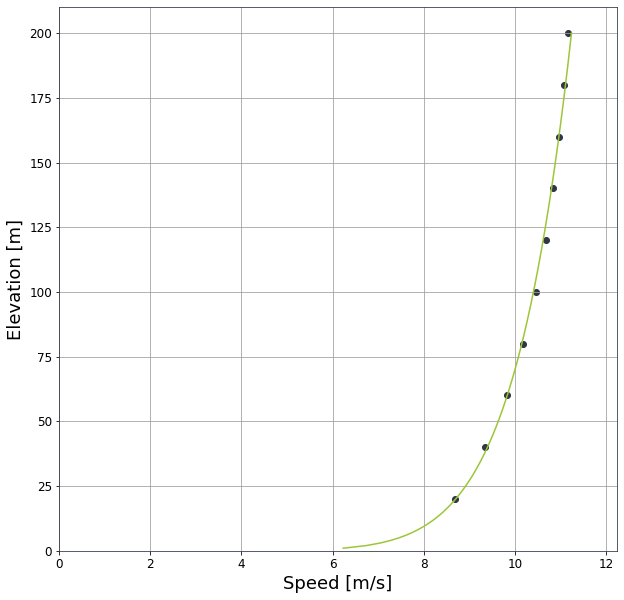

In [11]:
average_power_law = bw.Shear.Average(data[wspd_avg_col_names], wspd_avg_col_names_heights)

The above plot shows the average shear profile for this station. The average shear value, alpha, can be extracted from the resulting object as show below.

In [12]:
print('The average shear alpha value for this station is: ', round(average_power_law.alpha, 2))

The average shear alpha value for this station is:  0.11


### Plot shear by direction sector

For this plot a single wind direction measurement is required. The below function selects the first, which is the top most, wind speed and wind direction measurements. You can of course overwrite this.

In [13]:
# wspd_main = meas_sta.measurements.wspd_names[0]
# wdir_main = meas_sta.measurements.wdir_names[0]
wspd_main = wspd_avg_col_names[5]
wdir_main = 'lidar_lidar18m_WD_alg_03'
print('The main wind speed measurement for plotting is set to:\t\t{}'.format(wspd_main))
print('The main wind direction measurement for plotting is set to:\t{}'.format(wdir_main))

The main wind speed measurement for plotting is set to:		lidar_lidar118m_Z10_HorizWS
The main wind direction measurement for plotting is set to:	lidar_lidar18m_WD_alg_03


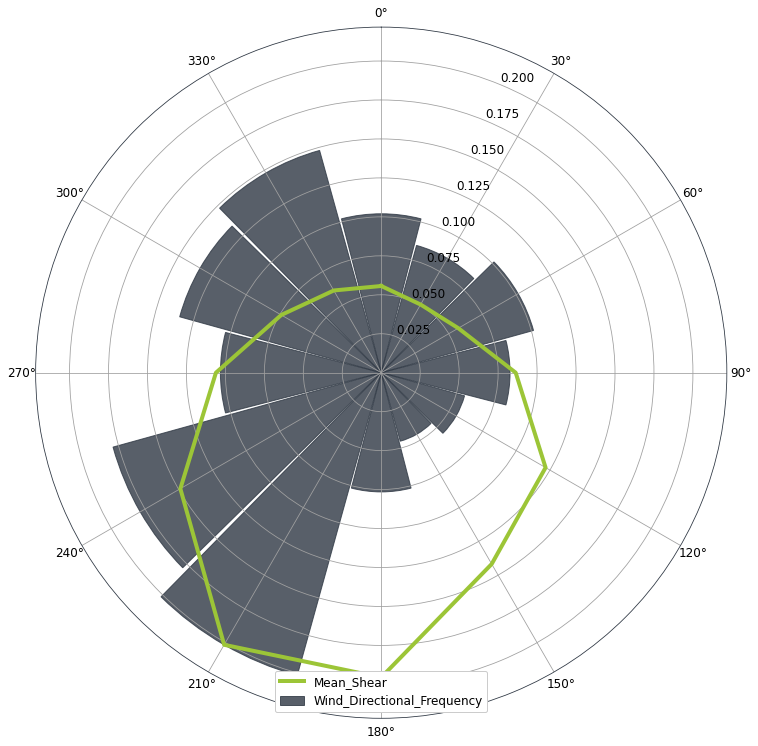

In [14]:
shear_by_sec_obj_pw_law = bw.Shear.BySector(data[wspd_avg_col_names], 
                                            wspd_avg_col_names_heights, 
                                            data[wdir_main], calc_method='power_law')

The above plot shows how the shear alpha value can change depending on the direction of the wind flow. Also show is how frequent the wind blows from each direction sector so you can assess if a high shear value from a particular direction has a big impact.

### Shear plot by time of day

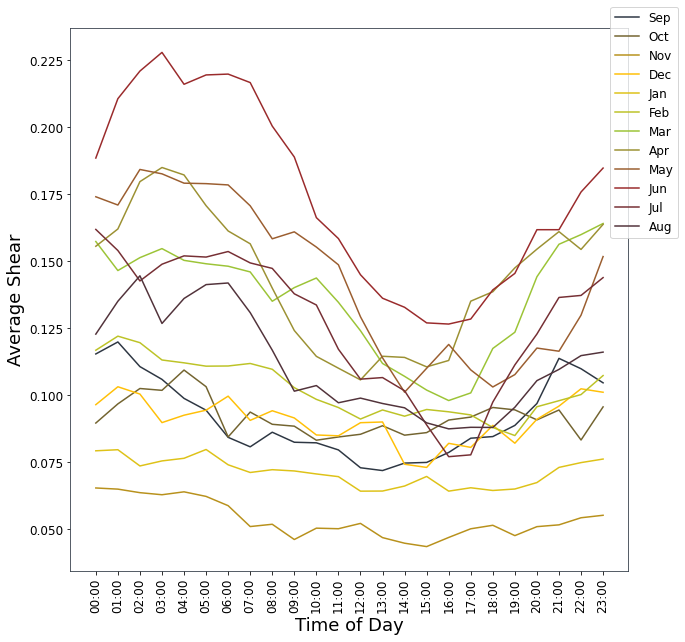

In [15]:
shear_by_time_of_day_obj_pw_law = bw.Shear.TimeOfDay(data[wspd_avg_col_names], wspd_avg_col_names_heights, 
                                                     calc_method='power_law')

The above plot shows the daily profile of the shear alpha value for each calendar month. This shows a more diurnal effect during the summer months thant the winter ones.

An alternative view of this plot is shown below as a heatmap.

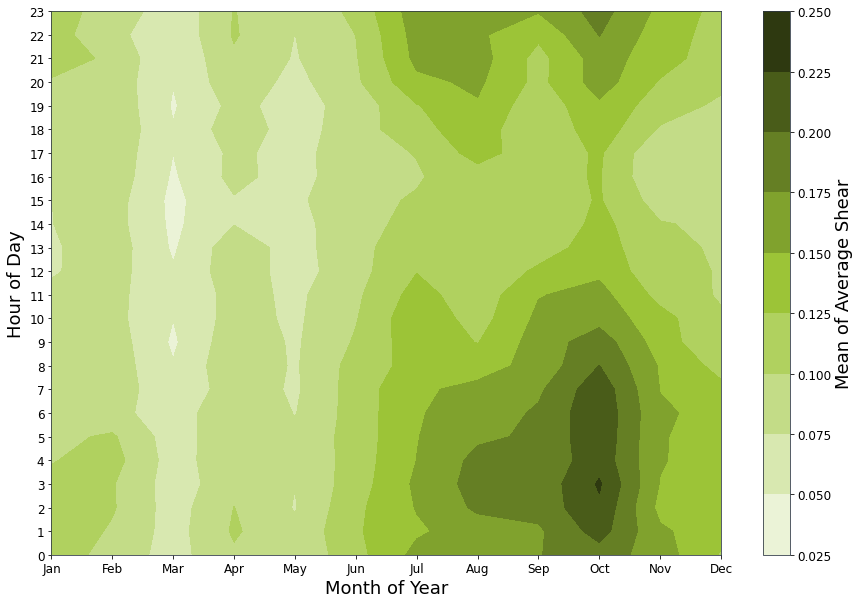

In [16]:
shear_by_time_of_day_obj_pw_law = bw.Shear.TimeOfDay(data[wspd_avg_col_names], wspd_avg_col_names_heights, 
                                                     calc_method='power_law', plot_type='12x24')

## Conclusions

The above work shows how useful the WRA Data Model can be in developing automated workflows along with the use of the brightwind library. In this particular case there were some modifications needed to be performed on the data which was outside of our control. Nevertheless, this demonstrates the possibilities when the format of the timeseries data received can be controlled.

Obviously, what is missing in this workflow are the quality control checks and cleaning of the timeseries data. Therefore, treat any results from this sample workflow with caution